In [1]:
# pip install ipympl
# pip install mpl_point_clicker

# Common Libraries

In [1]:
import os
import cv2
import re
import numpy as np
import nibabel as nb
import pandas as pd
import matplotlib.pylab as plt
from nilearn.image import resample_to_img, math_img
from sklearn.cluster import KMeans
from mpl_point_clicker import clicker
from glob import glob
import json
from pathlib import Path

# Custom Libraries

In [2]:
import sys
sys.path.append("/home/seojin")
import surfAnalysisPy as surf # Dierdrichsen lab's library

sys.path.append("/home/seojin/Seojin_commonTool/Module")
from surface_analysis import vol_to_surf, surface_cross_section
from sj_brain_mask import fan_roi_mask_manager, brain_mask

# Params

In [3]:
reference_img = "/mnt/ext1/seojin/HR/exp_blueprint_0324v4/fMRI_data/output/roi/mask/group_mask.nii.gz"
surf_hemisphere = "R" # L: Left, R: right
surf_resolution = 32

surf_dir_path = f"/mnt/sda2/Common_dir/Atlas/Surface/fs_LR_{surf_resolution}"
pial_surf_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.pial.surf.gii")
white_surf_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.white.surf.gii")
template_surface_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.flat.surf.gii")

temp_dir = "/mnt/ext1/seojin/temp/rois"
os.makedirs(temp_dir, exist_ok = True)

sulcus_path = os.path.join(surf_dir_path, "borders", f"{surf_hemisphere}_sulcus.json")

surface_mask_dir_path = os.path.join(surf_dir_path, "FAN")
os.makedirs(surface_mask_dir_path, exist_ok = True)

# Functions

In [4]:
# 유클리드 거리 계산 함수
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

# Region Growing 알고리즘
def region_growing(data, seed_index, threshold=1.0):
    visited = set()  # 방문한 좌표
    queue = [seed_index]  # 탐색 큐
    region = []  # 결과 영역

    while queue:
        current_index = queue.pop(0)
        if current_index in visited:
            continue

        # 현재 좌표를 결과에 추가하고 방문 처리
        visited.add(current_index)
        region.append(data[current_index])

        # 현재 좌표
        current_point = data[current_index]

        # 모든 다른 점들과 거리 계산
        for idx, point in enumerate(data):
            if idx not in visited and euclidean_distance(current_point, point) <= threshold:
                queue.append(idx)

    return np.array(region)

# Fan ROI

In [5]:
fan_roi_manager = fan_roi_mask_manager(fan_info_path = "/mnt/ext1/seojin/mask/Fan280/fan280_fullname.csv", 
                                       mask_dir_path = "/mnt/ext1/seojin/mask/Fan280", 
                                       reference_img = reference_img)

In [6]:
roi_keywords = [
        [f"{surf_hemisphere}t", "superior", "frontal", "gyrus"],
        [f"{surf_hemisphere}t", "middle", "frontal", "gyrus"],
        [f"{surf_hemisphere}t", "inferior", "frontal", "gyrus"],
        [f"{surf_hemisphere}t", "precentral"],
        [f"{surf_hemisphere}t", "postcentral"],
        [f"{surf_hemisphere}t", "inferior", "parietal"],
        [f"{surf_hemisphere}t", "superior", "parietal"],
        [f"{surf_hemisphere}t", "orbital"],
        [f"{surf_hemisphere}t", "paracentral"],
        [f"{surf_hemisphere}t", "precuneus"],
        [f"{surf_hemisphere}t", "insular"],
        [f"{surf_hemisphere}t", "medioventral", "occipital"],
        [f"{surf_hemisphere}t", "lateral", "occipital"],
        [f"{surf_hemisphere}t", "fusiform"],
        [f"{surf_hemisphere}t", "cingulate"],
        [f"{surf_hemisphere}t", "superior", "temporal"],
        [f"{surf_hemisphere}t", "middle", "temporal"],
        [f"{surf_hemisphere}t", "inferior", "temporal"],
]

In [7]:
roi_nick_names = []
for roi_keyword in roi_keywords:
    without_orientation = "_".join(roi_keyword[1:])

    if without_orientation == "superior_frontal_gyrus":
        roi_nick_names.append("SFL")
    elif without_orientation == "middle_frontal_gyrus":
        roi_nick_names.append("MFL")
    elif without_orientation == "inferior_frontal_gyrus":
        roi_nick_names.append("IFL")
    elif without_orientation == "precentral":
        roi_nick_names.append("M1")
    elif without_orientation == "postcentral":
        roi_nick_names.append("S1")
    elif without_orientation == "inferior_parietal":
        roi_nick_names.append("IPL")
    elif without_orientation == "superior_parietal":
        roi_nick_names.append("SPL")
    elif without_orientation == "orbital":
        roi_nick_names.append("OB")
    elif without_orientation == "paracentral":
        roi_nick_names.append("ParaC")
    elif without_orientation == "precuneus":
        roi_nick_names.append("PC")
    elif without_orientation == "insular":
        roi_nick_names.append("IN")
    elif without_orientation == "medioventral_occipital":
        roi_nick_names.append("MO")
    elif without_orientation == "lateral_occipital":
        roi_nick_names.append("LO")
    elif without_orientation == "fusiform":
        roi_nick_names.append("FF")
    elif without_orientation == "cingulate":
        roi_nick_names.append("CG")
    elif without_orientation == "superior_temporal":
        roi_nick_names.append("STL")
    elif without_orientation == "middle_temporal":
        roi_nick_names.append("MTL")
    elif without_orientation == "inferior_temporal":
        roi_nick_names.append("ITL")

# Make temporary rois

In [8]:
existing_roi_file_paths = glob(temp_dir + f"/{surf_hemisphere}t*")

roi_file_paths = []
for roi_key in roi_keywords:
    temp_file_name = "_".join(roi_key) + ".nii.gz"
    temp_file_path = os.path.join(temp_dir, temp_file_name)

    if temp_file_path in existing_roi_file_paths:
        pass
    else:
        roi_img = fan_roi_manager.search_roi(roi_key)
        nb.save(roi_img.mask_nifti_img, temp_file_path)
    roi_file_paths.append(temp_file_path)

# Load surface data

In [9]:
temploate_surface_data = nb.load(template_surface_path)
vertex_data = temploate_surface_data.darrays[0].data

n_vertex, _ = vertex_data.shape

# Original surface

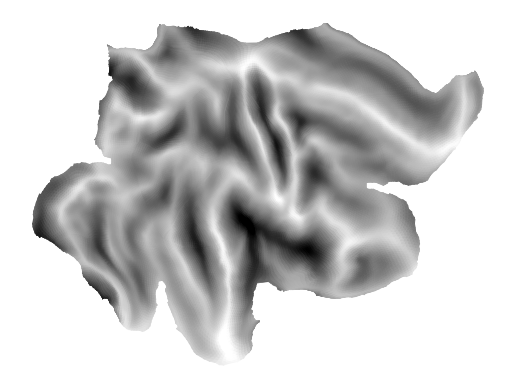

In [10]:
surf_ax = surf.plot.plotmap(data = np.zeros(n_vertex), 
                            surf = f"fs{surf_resolution}k_{surf_hemisphere}",
                            threshold = 0.01)

# Surface representation

In [11]:
cmap = "CMRmap"
alpha = 0.3

In [12]:
surf_roi_dummy = np.zeros(n_vertex)
surf_roi_labels = np.repeat("|", n_vertex).astype("<U5")

roi_value = 1
for path in roi_file_paths:
    surf_roi = vol_to_surf(path, pial_surf_path, white_surf_path, depths = [1.0])

    # Data
    surf_roi_data = np.where(surf_roi > 0.001, roi_value, 0)
    surf_roi_dummy = np.where(surf_roi_dummy == 0, surf_roi_data, surf_roi_dummy)
    roi_value += 1

    # Label
    brodmann_number = Path(path).stem.split(".")[0].replace("BA", "")
    surf_roi_label = np.where(surf_roi > 0.001, brodmann_number, "")
    stack_surf_roi_label = np.char.add(surf_roi_label, "|")
    surf_roi_labels = np.char.add(surf_roi_labels, stack_surf_roi_label)
surf_roi_labels = [re.sub(r'\|+', '|', label) for label in surf_roi_labels]

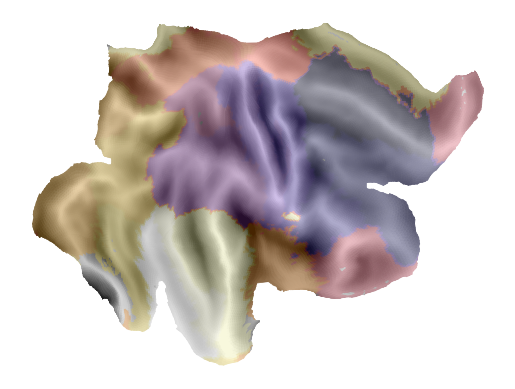

In [13]:
ax = surf.plot.plotmap(data = surf_roi_dummy, 
                       surf = f"fs{surf_resolution}k_{surf_hemisphere}",
                       threshold = 0.01,
                       alpha = alpha,
                       cmap = cmap)

In [14]:
# Save roi names
np.save(os.path.join(surface_mask_dir_path, f"{surf_hemisphere}_roi_values.npy"), arr = surf_roi_dummy)
np.save(os.path.join(surface_mask_dir_path, f"{surf_hemisphere}_rois.npy"), arr = surf_roi_labels)

# ROI - text

In [15]:
uq_roi_value = np.unique(surf_roi_dummy)
uq_roi_value = uq_roi_value[uq_roi_value != 0]

In [16]:
seed_idx = 0

mean_vertex_loc_info = {} 
for roi_name, roi_value in zip(roi_nick_names, uq_roi_value):
    vertex_locs = vertex_data[surf_roi_dummy == roi_value][:, :2] # xy coordinates
    if roi_name in ["OB", "ParaC", "PC", "LO", "MO"]:
        region = region_growing(vertex_locs, seed_idx, threshold = 10)
    else:
        region = vertex_locs
    
    mean_vertex_loc = list(np.mean(region, axis = 0))
    mean_vertex_loc_info[roi_name] = mean_vertex_loc


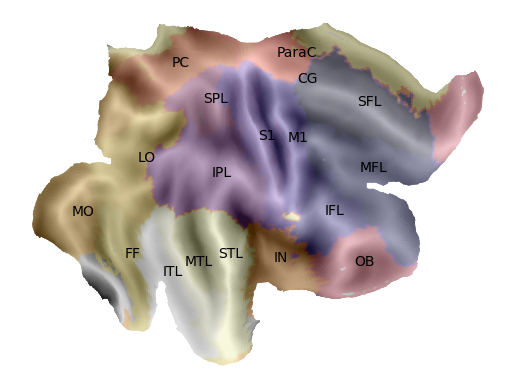

In [17]:
for i, roi_name in enumerate(mean_vertex_loc_info):
    loc = mean_vertex_loc_info[roi_name]
    ax.text(x = loc[0], y = loc[1], s = roi_name)
ax.get_figure()

In [18]:
# Save dictionary to a JSON file
for name in mean_vertex_loc_info:
    mean_vertex_loc_info[name] = np.array(mean_vertex_loc_info[name]).astype(float).tolist()
    
with open(os.path.join(surface_mask_dir_path, f"{surf_hemisphere}_roi_vertex_info.json"), 'w') as file:
    json.dump(mean_vertex_loc_info, file)

# Sulcus drawing

In [19]:
if os.path.exists(sulcus_path):
    with open(sulcus_path, "r") as file:
        marking_data_info = json.load(file)
else:
    marking_data_info = {}

In [20]:
del marking_data_info["Intra parietal sulcus"]

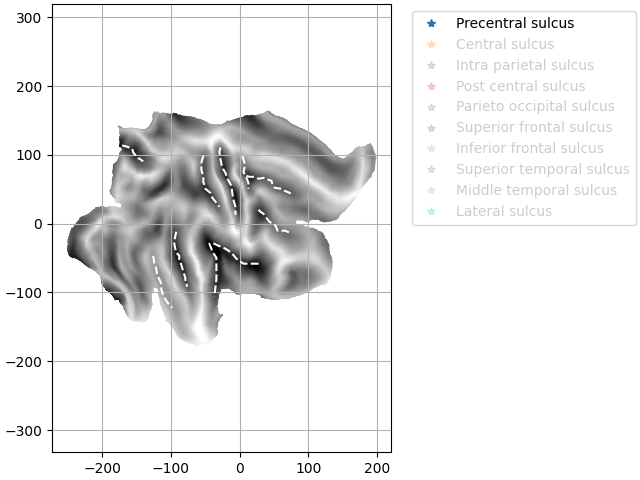

In [21]:
%matplotlib ipympl

fig, ax = plt.subplots(constrained_layout=True)
marking_labels = ["Precentral sulcus",
                  "Central sulcus", 
                  "Intra parietal sulcus",
                  "Post central sulcus",
                  "Parieto occipital sulcus",
                  "Superior frontal sulcus",
                  "Inferior frontal sulcus",
                  "Superior temporal sulcus",
                  "Middle temporal sulcus",
                  "Lateral sulcus"]
klicker = clicker(ax, marking_labels, markers = np.repeat("*", len(marking_labels)))

ax_ = surf.plot.plotmap(data = np.zeros(n_vertex), 
                        surf = f"fs{surf_resolution}k_{surf_hemisphere}",
                        threshold = 0.01)
ax_.grid(True)
ax_.axis("on")

for sulcus_name in marking_data_info:
    ax_.plot(np.array(marking_data_info[sulcus_name])[:, 0], 
             np.array(marking_data_info[sulcus_name])[:, 1], 
             color = "white",  
             linestyle='dashed')

In [22]:
# Save sulcus
click_info = klicker.get_positions()
for sulcus_name in click_info:
    if len(click_info[sulcus_name]) > 0:
        marking_data_info[sulcus_name] = np.array(click_info[sulcus_name]).tolist()

In [23]:
with open(sulcus_path, "w") as file:
    json.dump(marking_data_info, file)

# Show sulcus

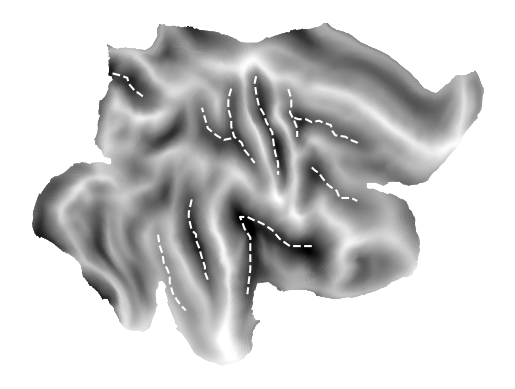

In [24]:
%matplotlib inline

for sulcus_name in marking_data_info:
    surf_ax.plot(np.array(marking_data_info[sulcus_name])[:, 0], 
                 np.array(marking_data_info[sulcus_name])[:, 1], 
                 color = "white",  
                 linestyle='dashed')
surf_ax.get_figure()